# ⭐Imports


**Most Relevant Papers** <br />
https://arxiv.org/pdf/1407.5675.pdf <br />
https://arxiv.org/pdf/1701.08784.pdf

In [10]:
#from utils import *

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from IPython.display import display
import time

# Possibly Redundant
from scipy import ndimage, misc
from skimage.feature import peak_local_max
from skimage import data, img_as_float

%matplotlib inline

---

# ⭐Step 0: Read the data (tar.gz file) & Explore it
**Read**

As a first step, we unzipped the tar.gz file into a .dat file using 7-zip. 
Then, we convert the .dat file into a string and then into a DataFrame.

.strip() --> remove spaces on the sides

.split() --> separate values by spaces (otherwise we'd get a single conlumn)

In [11]:
# Convert .dat file into string (list comprehension)
datContent = [i.strip().split() for i in open("tth_semihad.dat").readlines()]

# Convert list into DataFrame
mydata = pd.DataFrame(datContent)

**Explore**

**Physics**

Jonas: "The file was produced from a simulation of pp->tt~H where the top decays hadronically
and the anti-top decays leptonically. <br /> I selected events with exactly 1 fat jet with R=1.5."


**Notes**
- The rows represent events (of 1 fat jet each, R = 1.5) 
- The first column represents the number of constituents of the jet  
- The following columns represent the coordinates of the constituents, η, φ, pT, cycling in that order. <br />(e.g. columns 1, 2, 3 are η, φ, pT for the 1st constituent, columns 4, 5, 6 are η, φ, pT for the 2nd constituent etc.)

<br />

- -infinity < η < infinity 
- -π < φ < π
- pT[GeV] > 0


In [12]:
# # Display the data
# mydata = mydata.rename(columns={0: 'Const'})
# display(mydata.head())

# # Print statements
# events = mydata.shape[0]
# print('There are {} rows (events).'.format(events))
# print('The maximum number of constituents in an event is {}.'.format((mydata.shape[1] - 1) // 3))

## Display data types
#print('\nData Types: \n', mydata.dtypes)

## Descriptive statistics on data
#mydata.describe()

---

# ⭐Step 1: Preprocessing

🔴 Define helper function that
- drops the constituents column 
- converts NaN to 0
- converts values to floats

In [13]:
def preprocess(event1):
    '''
    -Extracts no. of constituents
    -Drops constituents column
    -Replaces NaN values with 0
    -Converts all values to floats
    
    Input: Series (event) to be processed
    Output: Processed Series, constituents Series 
    '''
    
    # Create series copy
    event = event1.copy(deep=True)
    
    # Drop constituents from series
    event = event.drop(event.index[0])
    
    # Replace NaN with 0
    event = event.fillna(0)

    # Convert values to floats
    event = event.astype(float)
    
    return event

# ⭐Step 2: Create Image

🔴 Define Helper Function that turns an event into an image
- Bins coordinates (η, φ, pT)
- Creates image using np.histogram2d(). pd.DataFrame()

In [14]:
def create_image(event1, R=1.5, pixels=60):
    
    '''
    Creates an image of single event, or multiple events (input can be either Series or DataFrame). If DataFrame, then average image is created.  
    
    Input: series
    Output: array
    
    table: if df=True, then display the image as a DataFrame as well
    '''
    
    # Create copy of df so that it's not accidentally modified
    event = event1.copy(deep=True)
    
    # If input is Series (single event) then turn into DataFrame. This makes it so that single events are processed correctly
    if isinstance(event, pd.Series):
        event = pd.DataFrame(event).T

    # Initiate bin lists
    bin_h = []
    bin_f = []
    bin_p = []

    # Define max number of constituents 
    max_const = event.shape[1] // 3

    # For all rows
    #for i in range(event.shape[0]):             

    # For all constituents (I tested it using only meaningful constituents from first column and the code was slower)
    for i in range(max_const):
        # Add constituent's coordinates to bin lists
        bin_h.append(list(event.iloc[0][::3])[i])
        bin_f.append(list(event.iloc[0][1::3])[i])
        bin_p.append(list(event.iloc[0][2::3])[i])

# Tried not doing it for pT=0 constituents. Was less efficient
#     i = 0
#     while i < max_const and list(event.iloc[0][2::3])[i] != 0.:
#         bin_h.append(list(event.iloc[0][::3])[i])
#         bin_f.append(list(event.iloc[0][1::3])[i])
#         bin_p.append(list(event.iloc[0][2::3])[i])
#         i += 1

    

    # Turn lists into Series
    bin_h = pd.Series(bin_h)
    bin_f = pd.Series(bin_f)
    bin_p = pd.Series(bin_p)

   # Define no. of bins
    bin_count = np.linspace(-R, R, pixels + 1)

    # Create bins from -R to R (using bins vector)
    bins = np.histogram2d(bin_h, bin_f, bins=bin_count, weights=bin_p)[0] # x and y are switch because when the bins were turned into a Series the shape[0] and shape[1] were switched

    # Convert to DataFrame
    image = bins
    
    return image

🔴 Define Helper Function that 
- Reads directly from the file
- Returns an average image

**NOTE:** event_no list implementation for multiple images is not working properly

In [47]:
def average_image(pixels=60, R=1.5, event_no=12178, display=False):
    '''
    pixels: Image Resolution, int.
    event_no: # of events for which images be created. If int, then single image (faster) If list, then multiple images (slower)
    '''

    image = np.zeros((pixels, pixels))                           # Define initial image
    a = 0                                                        # Define Counter
    
    
    #Return single image
    if type(event_no) == int and display == False:
        
        with open("tth_semihad.dat") as infile:
            for line in infile:

                event=line.strip().split()
                event = pd.Series(event)                         # Turn into Series
                event = preprocess(event)                        # Preprocess
                #event = normalise_p(event)                       # Normalise pT's
                max123 = extract_max123(event)                   # Extract maxima
                event = center(event, max123)                    # Center 
                #event = rotate(event, max123)                   # Rotate 
                #event = flip(event, max123)                     # Flip 
                event = create_image(event, pixels=pixels, R=R)  # Create image
                image += event                                   # Add event image to average image
                #image = np.log(image)                            # Log transform pT's for smaller numbers
                #image /= np.amax(image)                          # Normalise final image between 0 and 1
                event = max123 = None                            # Delete from memory

                a += 1
                if a == event_no:                                 # Break if max sample size for average image is exceeded 
                    return image
                    break

                    
                
    
    # Display Images
    elif display == True and type(event_no) == list:
                
        with open("tth_semihad.dat") as infile:
            for line in infile:

                event=line.strip().split()
                event = pd.Series(event)                         # Turn into Series
                event = preprocess(event)                        # Preprocess
                #event = normalise_p(event)                       # Normalise pT's
                max123 = extract_max123(event)                   # Extract maxima
                event = center(event, max123)                    # Center 
                #event = rotate(event, max123)                   # Rotate 
                #event = flip(event, max123)                     # Flip 
                event = create_image(event, pixels=pixels, R=R)  # Create image
                image += event                                   # Add event image to average image
                #image = np.log(image)                            # Log transform pT's for smaller numbers
                #image /= np.amax(image)                          # Normalise final image between 0 and 1
                event = max123 = None                            # Delete from memory

                a += 1
                if a in event_no:
                    sns.heatmap(image, robust=True)
                    plt.show()
#                     sns.heatmap(image)
#                     plt.show()
                    if a >= max(event_no):                        # Break if max sample size for average image is exceeded 
                        break
                    
    
        
    # Return multiple images
    ##### Not working properly
    elif type(event_no) == list:
        
        images = []                                         # List containing the output images
        
        with open("tth_semihad.dat") as infile:
            for line in infile:

                event=line.strip().split()
                event = pd.Series(event)                         # Turn into Series
                event = preprocess(event)                        # Preprocess
                #event = normalise_p(event)                       # Normalise pT's
                max123 = extract_max123(event)                   # Extract maxima
                event = center(event, max123)                    # Center 
                #event = rotate(event, max123)                   # Rotate 
                #event = flip(event, max123)                     # Flip 
                event = create_image(event, pixels=pixels, R=R)  # Create image
                image += event                                   # Add event image to average image
                #image = np.log(image)                            # Log transform pT's for smaller numbers
                #image /= np.amax(image)                          # Normalise final image between 0 and 1
                event = max123 = None                            # Delete from memory

                a += 1
                if a in event_no:                                 # Store images
                    images.append(image)                                   
                    if a >= max(event_no):                        # Break if max sample size for average image is exceeded 
                        return images
                        break

### Example (Image Progression)

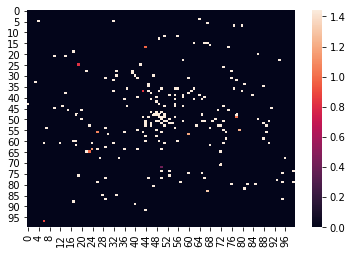

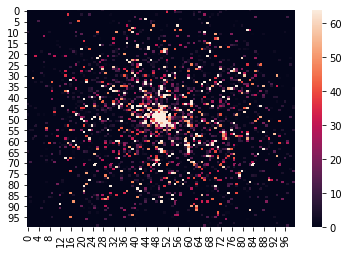

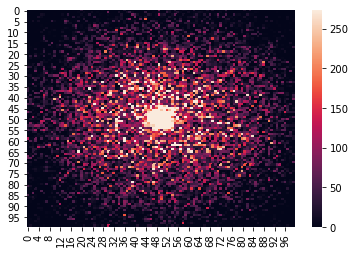

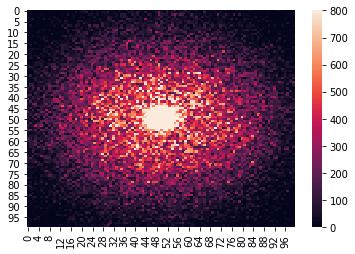

In [66]:
average_image(pixels = 100, event_no=[25, 300, 3000, 12000], display=True)

In [50]:
image = average_image(event_no=500)

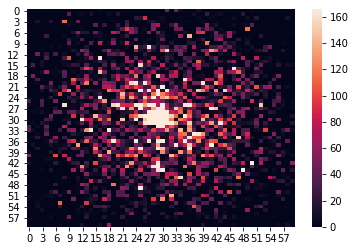

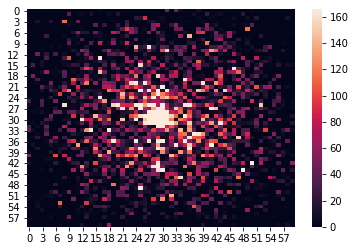

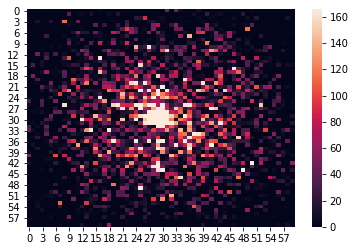

In [56]:
sns.heatmap(image, robust=True)
plt.show()
sns.heatmap(imagelist[0], robust=True)
plt.show()
sns.heatmap(imagelist[1], robust=True)
plt.show()

### 🔴 (Sidetrack) Normalise/Log pT (Still doesn't work without robust)
Note: the log transformation can simply be done on the final ndarray and it's much more efficient (and doesnt require a function)

Also tried normalising the whole image using image /= np.amax(image) and results were even worse. **Though this might be a good form to feed it to the algorithm in**

In [17]:
def normalise_p(event1):
    # Define p indices to be used later
    p_indices = event1[2::3].index

    # Create copy of event
    event = event1.copy(deep=True)

    # Calculate sum (only for normalisation)
    total_p = 0
    for p_index in p_indices:
        total_p += event.iloc[2::3][p_index]
    
    # For all p in the event
    for p_index in p_indices:             

        # Define Useful Quantities
        num_index = event.name                   
        
        # p Normalisation
        event.iloc[2::3][p_index] /= total_p                                         # Normalise
        #event.iloc[2::3][p_index] = math.log(event.iloc[2::3][p_index], 10)         # Log Transform

        
#     if output == 'event':
#         return event
    return event

# ⭐Step 3: Extract Maxima

🔴 Define Helper Function that 

returns 3 vectors, one for each pT and its η, φ. (For the three maximum pT's)

- **1st vector**: 1st maximum pT and its η, φ
- **2nd vector**: 2nd maximum pT and its η, φ
- **3rd vector**: 3rd maximum pT and its η, φ

In [18]:
def extract_max123(event1):

    '''
    Input: event (row). 
    e.g. mydata_prep.iloc[0]

    Output[0]: [Series of 1st max p, φ, η]
    Output[1]: [Series of 2nd max p, φ, η]
    Output[2]: [Series of 3rd max p, φ, η]
    '''


    # Create event copy
    event = event1.copy(deep=True)

    # Separate η, φ, pT
    hdata = event[::3]
    fdata = event[1::3]
    pdata1 = event[2::3]



    # 1. Extract index of maximum pT
    maxid1 = pdata1.idxmax()
    maxlist1 = []

    # 2. Extract max η, φ, pT for event
    if pdata1.max() != 0:                                                                     # Brief explanation of if statement below)
        maxlist1.append([event.iloc[maxid1-1], event.iloc[maxid1-2], event.iloc[maxid1-3]])   # From event, add to list the max pT and its η, φ
    else:
        maxlist1.append([0., event.iloc[maxid1-2], event.iloc[maxid1-3]])                    # If max pT is 0, then add it as 0 and not the first value

    # 3. Create & Display dataframe of max pT, η, φ
    row_max1 = pd.Series(data=maxlist1[0], index=['pT', 'φ', 'η'])




    # 0. Set Max pT to 0 to find next Max pT
    pdata2 = pdata1.copy(deep=True)
    pdata2.loc[maxid1] = 0

    # 1. Extract index of maximum pT
    maxid2 = pdata2.idxmax()
    maxlist2 = []

    # 2. Extract max η, φ, pT for event
    if pdata2.max() != 0:                                                                     # Brief explanation of if statement below)
        maxlist2.append([event.iloc[maxid2-1], event.iloc[maxid2-2], event.iloc[maxid2-3]])   # From event, add to list the max pT and its η, φ
    else:
        maxlist2.append([0., event.iloc[maxid2-2], event.iloc[maxid2-3]])                    # If max pT is 0, then add it as 0 and not the first value

    # 3. Create & Display dataframe of max pT, η, φ
    row_max2 = pd.Series(data=maxlist2[0], index=['pT', 'φ', 'η'])




    # 0. Set Max pT to 0 to find next Max pT
    pdata3 = pdata2.copy(deep=True)
    pdata3.loc[maxid2] = 0

    # 1. Extract index of maximum pT
    maxid3 = pdata3.idxmax()
    maxlist3 = []

    # 2. Extract max η, φ, pT for event
    if pdata3.max() != 0:                                                                     # Brief explanation of if statement below)
        maxlist3.append([event.iloc[maxid3-1], event.iloc[maxid3-2], event.iloc[maxid3-3]])   # From event, add to list the max pT and its η, φ
    else:
        maxlist3.append([0., event.iloc[maxid3-2], event.iloc[maxid3-3]])                    # If max pT is 0, then add it as 0 and not the first value

    # 3. Create & Display dataframe of max pT, η, φ
    row_max3 = pd.Series(data=maxlist3[0], index=['pT', 'φ', 'η'])



    return row_max1, row_max2, row_max3

**Why the if statement?** (note to self) <br />
Because if maximum pT is 0 in the pdata vector, it picks the ID of the first pT by default as the max (because they're all 0). <br />
Then, it goes to the non-zero'd event vector and adds its non-zero pT as the max, when the value of that max should clearly have been 0.

So the if statement fixes this: <br />
- If max pT != 0, then add it as normal.
- If max pT = 0, then add '0' as its value instead. (with the coordinates of the first pT, which is incorrect, but this doesn't matter since pT = 0 are not taken into account in the image) <br />


---

# ⭐Step 4: Centre Image

For each row, we centre a new coordinate system so that the highest pT constituent's coordinates are (φ', η') = (0, 0). <br />
This corresponds to rotating and boosting along the beam direction to center the jet.

**φ Tranformation**<br />
For the φ transformation, we subtract the φ (of the max pT) from all φ's in that row. <br />
If the values exceed [-π, π], we add 2π to the final result (if it's <-π) or subtract 2π from the final result (if it's >π). This makes sure that no values exceed the original φ interval. <br />
This has the effect of making the φ (corresponding to the max pT for that row) equal to 0 in each row, and shifting the other φ's by that same angle, while maintaining a range of 2π. <br />

**η Transformation**<br />
How does η transform? We need a Lorentz Transformation. 

**Paper** (E) <br />
Histograms binned in
either the angular separation of events or the rapidity separation of events can
be contributed to by events whose centre of mass frames are boosted by arbitrary velocities with respect to the rest frame of the detector, the lab frame.
The resulting histograms are undistorted by these centre of mass frame boosts
parallel to the beam axis, as the dependent variable is invariant with respect
to this sub–class of Lorentz boosts.

**Paper** (F): make code cell below markdown to display


In [19]:
#<img src="h1.png" width="500"> <img src="h2.png" width="500">

🔴 Define Helper Function

In [20]:
def center(event1, max123, output='event', R=1.5, pixels=60):
    
    '''
    Centers image around (φ', η') = (0, 0). Both transformations are linear (so far). 
    
    event1: the event (row) to be transformed
    max123: list of 3 dataframes of max pT, η, φ. Obtained using the extract_max123() function
    output: 'event' to return a Series of the transformed event1. 'image' to return a transformed dataframe representing an image 
    '''
    
    # Define η, φ indices to be used later
    h_indices = event1[::3].index
    f_indices = event1[1::3].index

    # Create copy of event
    event = event1.copy(deep=True)

    
    
    # For all η, φ in the event
    for h_index, f_index in zip(h_indices, f_indices):             

        # Define Useful Quantities
        num_index = event.name                   # index of event, so that we can find its corresponding φ in the max123[0] dataframe of max pT's and φ, η's
        maxh = max123[0].loc['η']                # η of max1 pT value
        maxf = max123[0].loc['φ']                # φ of max1 pT value
        f = event.iloc[1::3][f_index]            # φ original value
        
        # η Transformation
        event.iloc[::3][h_index] -= maxh         # Subtract max η from current η
        
        # φ Transformation (Note: the if statements take periodicity into account, making sure that range does not exceed 2π)
        if (f - maxf) < -np.pi:
            event.iloc[1::3][f_index] = f + 2*np.pi - maxf

        elif (f - maxf) > np.pi:
            event.iloc[1::3][f_index] = f - 2*np.pi - maxf

        else: 
            event.iloc[1::3][f_index] -= maxf     # Subtract max φ from current φ


    if output == 'event':
        return event
    
    
    elif output == 'image':
        # Initiate bin lists
        bin_h = []
        bin_f = []
        bin_p = []

        # Define max number of constituents 
        max_const = event.shape[0] // 3
        # For all constituents
        for i in range(max_const):
            # Add constituent's η, φ, p to bins
            bin_h.append(list(event.iloc[::3])[i])
            bin_f.append(list(event.iloc[1::3])[i])
            bin_p.append(list(event.iloc[2::3])[i])

        # Turn lists into Series
        bin_h = pd.Series(bin_h)
        bin_f = pd.Series(bin_f)
        bin_p = pd.Series(bin_p)

        # Define no. of bins
        bin_count = np.linspace(-R, R, pixels + 1)

        # Create bins from -R to R and convert to DataFrame
        bins = np.histogram2d(bin_h, bin_f, bins=bin_count, weights=bin_p)[0] # x and y are switch because when the bins were turned into a Series the shape[0] and shape[1] were switched
        image = bins
        
        return image

# ⭐Step 5: Rotate Image

Rotate all constituents around (φ’,η’)=0 such that the constituent with the 2nd highest pT is at 12 o’clock, i.e. at  (φ’,η’)=(0,e) with e > 0.

**Paper (C)** <br />
"Rotation: Rotation is performed to remove the stochastic nature of the decay
angle relative to the η − φ coordinate system. This alignment can be done very
generally, by determining the principle axis [48] of the original image and rotating the imagine around the jet-energy centroid such that the principle axis
is always vertical."

#### Resources
https://stackoverflow.com/questions/53854066/pythonhow-to-rotate-an-image-so-that-a-feature-becomes-vertical

https://alyssaq.github.io/2015/computing-the-axes-or-orientation-of-a-blob/

https://pythontic.com/image-processing/pillow/rotate

https://www.askpython.com/python/examples/rotate-an-image-by-an-angle-in-python

https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/




🔴 Define Helper Function that

- 
- 
- 

# ⭐Step 6: Flip Image

Flip all the constituents such that the constituents with the 3rd highest pT is on the right-half plane, i.e. at (φ’,η’)=(f,e) with f > 0

🔴 Define Helper Function that

- 
- 
- 